In [172]:
import pandas as pd
import numpy as np
import pingouin as pg
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.formula.api import ols

In [173]:
def multiple_correlation(df):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length))
    p_values = np.zeros((length))
    
    for i, name in enumerate(names):
        formula = name + ' ~ ' + ' + '.join([n for j, n in enumerate(names) if j != i])
        mod = ols(formula=formula, data=df)
        res = mod.fit()
        correlation[i] = res.rsquared ** 0.5
        p_values[i] = res.f_pvalue
    
    return correlation, p_values

In [174]:
def partial_correlation(df, covar_name):
    names = [name for name in df.columns if name != covar_name]
    length = len(names)
    correlation = np.zeros((length, length))
    correlation[range(length), range(length)] = 1
    p_values = np.zeros((length, length))
    p_values[range(length), range(length)] = 1

    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names[i+1:]):
            res = pg.partial_corr(data=df, x=name1, y=name2, covar=covar_name, method='pearson')
            correlation[i, j] = correlation[j, i] = res['r'].values
            p_values[i, j] = p_values[j, i] = res['p-val'].values
    df_correlation = pd.DataFrame(correlation)
    df_p_values = pd.DataFrame(p_values)
    df_correlation.columns = df_p_values.columns = names
    df_correlation.index = df_p_values.index = names
    
    return df_correlation, df_p_values

In [175]:
def get_correlation(df, corr_function):
    names = df.columns
    length = len(names)
    correlation = np.zeros((length, length))
    correlation[range(length), range(length)] = 1
    p_values = np.zeros((length, length))
    p_values[range(length), range(length)] = 1

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            res = corr_function(df[names[i]], df[names[j]])
            correlation[i, j] = correlation[j, i] = res[0]
            p_values[i, j] = p_values[j, i] = res[1]
    df_correlation = pd.DataFrame(correlation)
    df_p_values = pd.DataFrame(p_values)
    df_correlation.columns = df_p_values.columns = names
    df_correlation.index = df_p_values.index = names
    
    return df_correlation, df_p_values

In [176]:
length = 5
names = [f'var{i + 1}' for i in range(length)]

In [177]:
df_base = pd.read_excel('ms-data2-2022.xlsx', sheet_name='2-2',
                   header=None, names=names)
df_base.head()

,var1,var2,var3,var4,var5
0,4.519,7.698,23.751,18.929,10.421
1,1.880,5.603,0.274,3.846,4.352
2,3.543,5.828,15.930,5.631,6.402
3,3.407,6.534,14.081,4.395,10.098
4,3.102,6.398,15.516,9.742,3.777


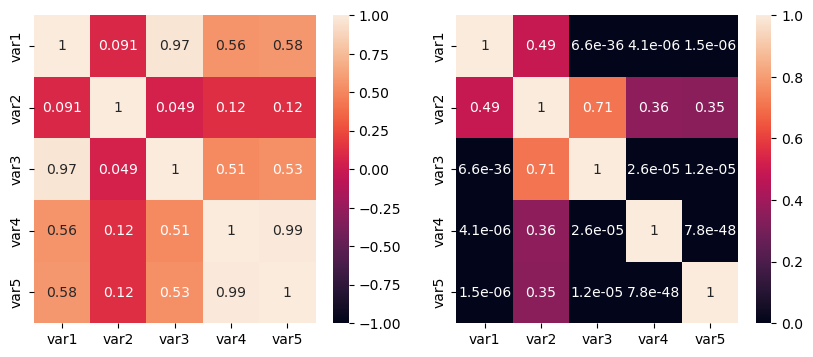

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = get_correlation(df_base, pearsonr)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1);
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2);

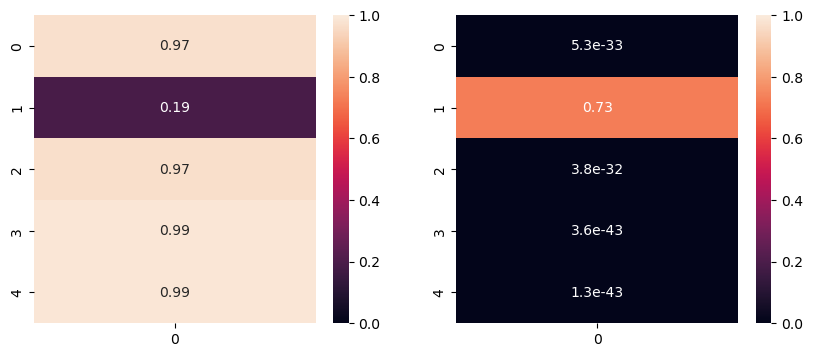

In [179]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
corr, p_vals = multiple_correlation(df_base)
sns.heatmap(corr[..., None], annot=True, vmin=0, vmax=1, ax=ax1);
sns.heatmap(p_vals[..., None], annot=True, vmin=0, vmax=1, ax=ax2);

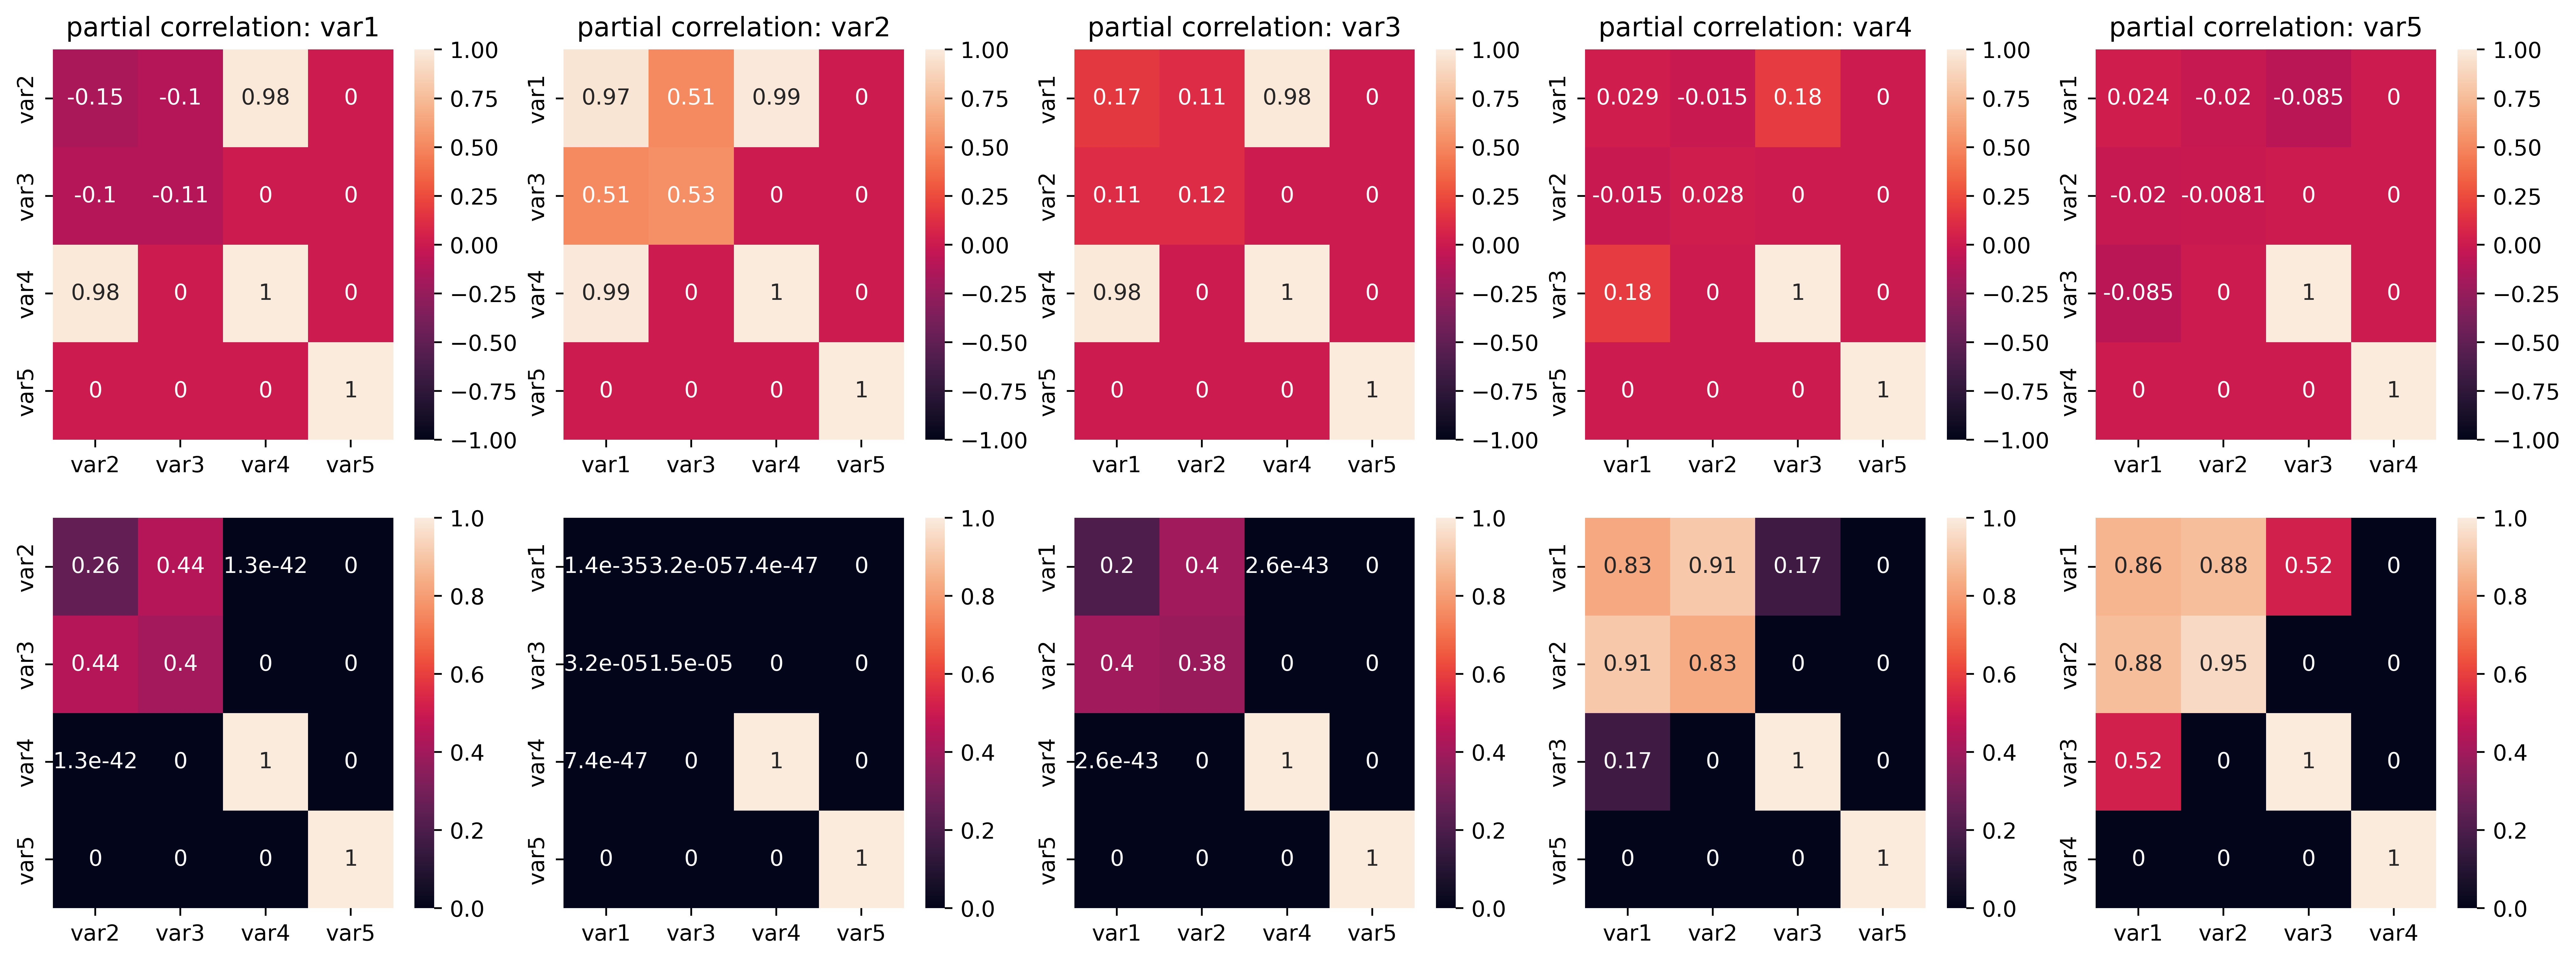

In [180]:
fig, axs = plt.subplots(2, length, figsize=(20, 7), dpi=500)

for i, cov_name in enumerate(names):
    axs[0, i].set_title('partial correlation: ' + cov_name)
    corr, p_vals = partial_correlation(df_base, cov_name)
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=axs[0, i]);
    sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=axs[1, i]);

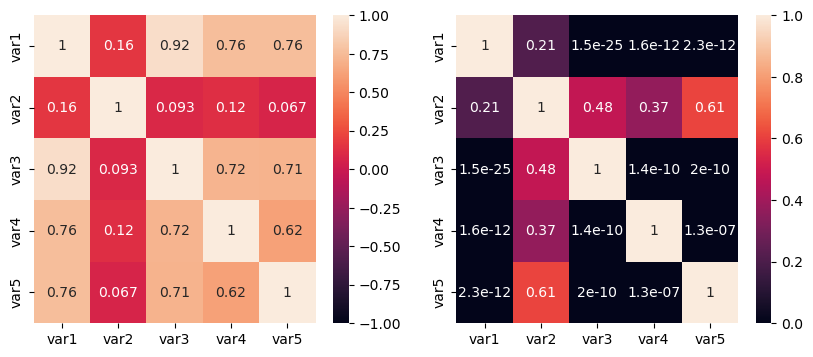

In [181]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = get_correlation(df_base, spearmanr)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1);
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2);

In [182]:
df_norm = pd.read_excel('ms-data2-2022.xlsx', sheet_name='1вар-адекв',
                   header=None, names=names)
df_norm.head()

,var1,var2,var3,var4,var5
0,8,10.746,19.059,-1.541,6.924
1,8,10.220,16.557,-4.043,5.923
2,8,8.615,18.565,-2.035,6.726
3,8,4.791,18.115,-2.485,6.546
4,8,2.831,19.900,-0.700,7.260


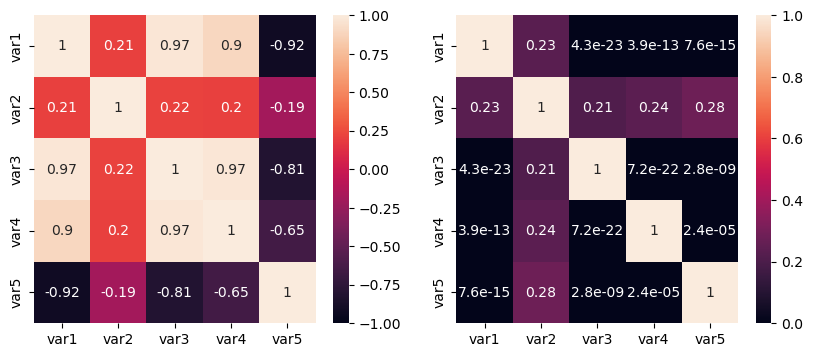

In [183]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = get_correlation(df_norm, pearsonr)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1);
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2);

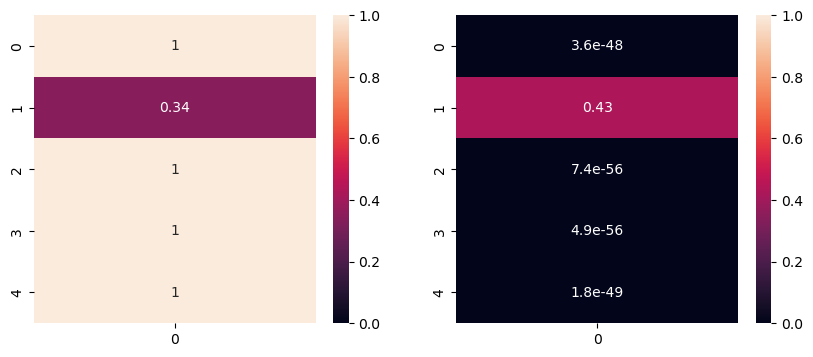

In [184]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
corr, p_vals = multiple_correlation(df_norm)
sns.heatmap(corr[..., None], annot=True, vmin=0, vmax=1, ax=ax1);
sns.heatmap(p_vals[..., None], annot=True, vmin=0, vmax=1, ax=ax2);

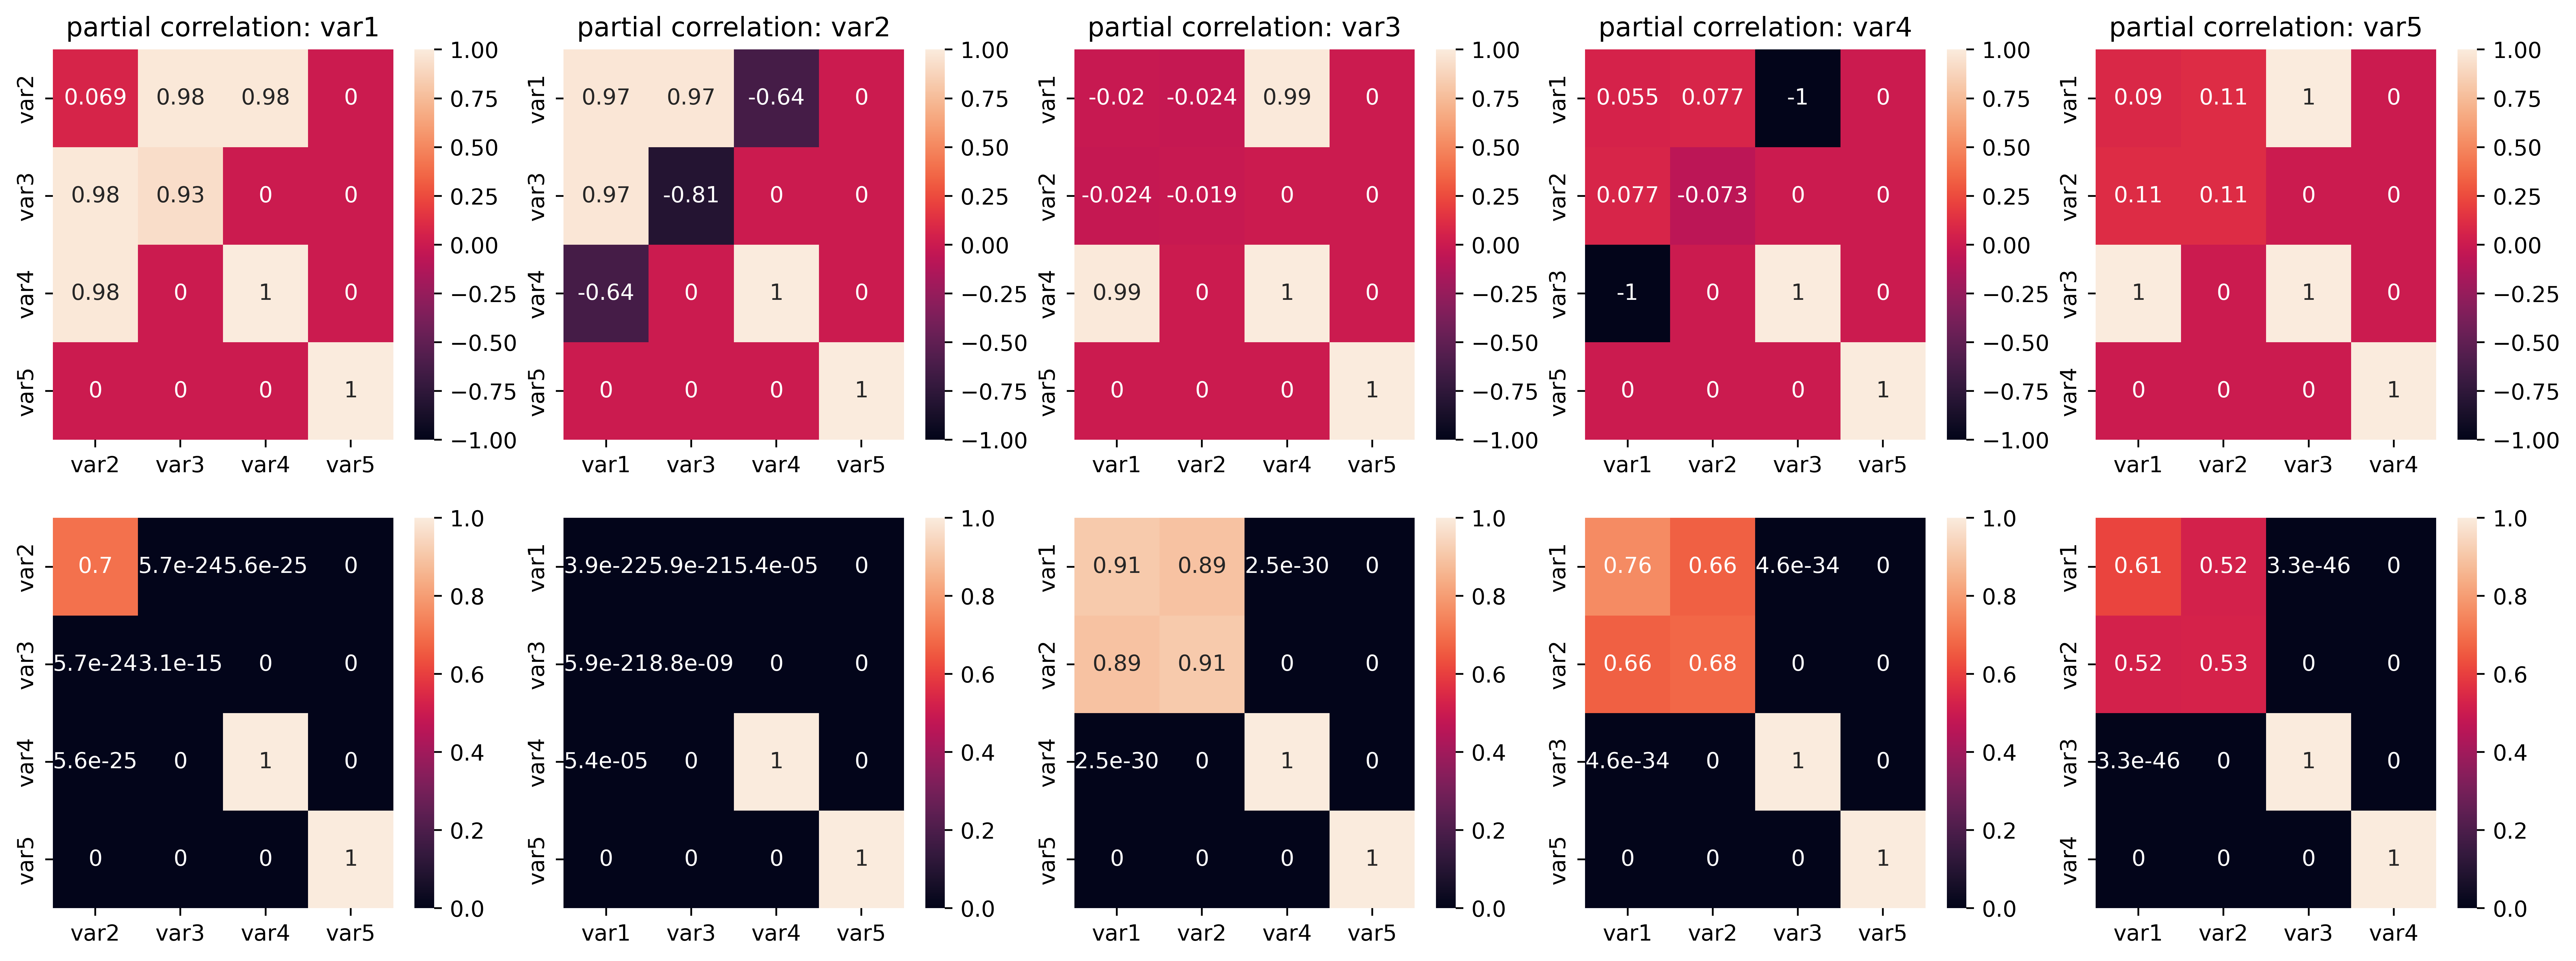

In [185]:
fig, axs = plt.subplots(2, length, figsize=(20, 7), dpi=500)

for i, cov_name in enumerate(names):
    axs[0, i].set_title('partial correlation: ' + cov_name)
    corr, p_vals = partial_correlation(df_norm, cov_name)
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=axs[0, i]);
    sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=axs[1, i]);

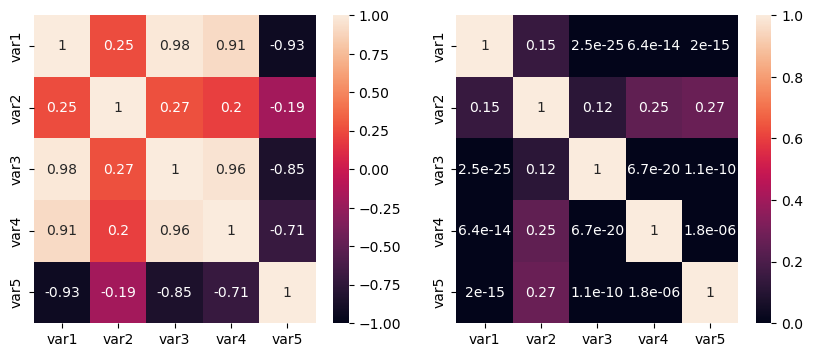

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

corr, p_vals = get_correlation(df_norm, spearmanr)
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, ax=ax1);
sns.heatmap(p_vals, annot=True, vmin=0, vmax=1, ax=ax2);